In [34]:
# import things
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [35]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [36]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'michal_232079_unet_model_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [37]:
# Define any functions you need to process the mask e.g. Task 2

im1 = cv2.imread('task5_test_image.png', 0)

# Threshold for detecting the edge
threshold = 70

# Horizontal and vertical lines to analyze
horizontal_line = im1[1503, 0:4112]  # Pixel values along the horizontal line
vertical_line = im1[0:3006, 2056]    # Pixel values along the vertical line

# Function to find edges by looping through the line
def find_edges(line, threshold):
    left_edge, right_edge = None, None
    n = len(line)
    
    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i-1] < threshold <= line[i] or line[i-1] >= threshold > line[i]:
            left_edge = i
            break
    
    # Loop from the right to find the last transition
    for i in range(n-1, 0, -1):
        if line[i] < threshold <= line[i-1] or line[i] >= threshold > line[i-1]:
            right_edge = i
            break
    
    return left_edge, right_edge

# Function to return a slice of found edges
def format(image):
    horizontal_line = image[1503, 0:4112]  
    vertical_line = image[0:3006, 2056]  
    left_x, right_x = find_edges(horizontal_line, threshold)
    top_y, bottom_y = find_edges(vertical_line, threshold)
    # Ensure the output region is a square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length
    return slice(top_y, bottom_y), slice(left_x, right_x)


# Analyze the horizontal line (x-coordinates)
left_x, right_x = find_edges(horizontal_line, threshold)

# Analyze the vertical line (y-coordinates)
top_y, bottom_y = find_edges(vertical_line, threshold)

In [38]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


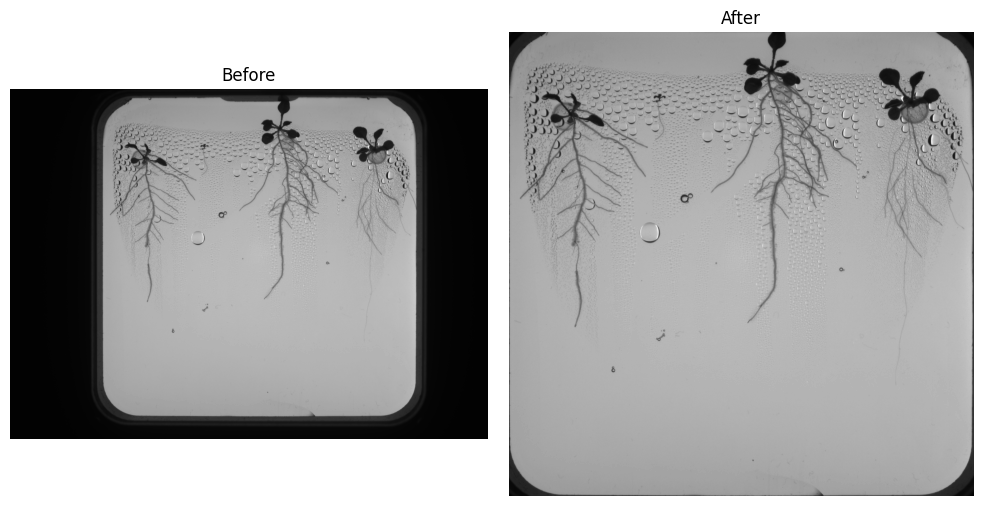

In [39]:
# Find the petri dish
petri_dish = image[format(image)]
petri_dish.shape


fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Display the first image
axes[0].imshow(im1, cmap = 'gray')
axes[0].axis('off')  # Turn off axes
axes[0].set_title("Before")

# Display the second image
axes[1].imshow(petri_dish, cmap = 'gray')
axes[1].axis('off')  # Turn off axes
axes[1].set_title("After")

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

In [40]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    Returns:
        padded_image (numpy.ndarray): The padded image.
        padding (tuple): The padding values as (top, bottom, left, right).
    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(
        image,
        top_padding,
        bottom_padding,
        left_padding,
        right_padding,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )

    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)

petri_dish_padded = padder(petri_dish, patch_size)

petri_dish_padded[0].shape

(2816, 2816)

Padding applied: Top=54, Bottom=55, Left=54, Right=55
4/4 [==============================] - 1s 173ms/step


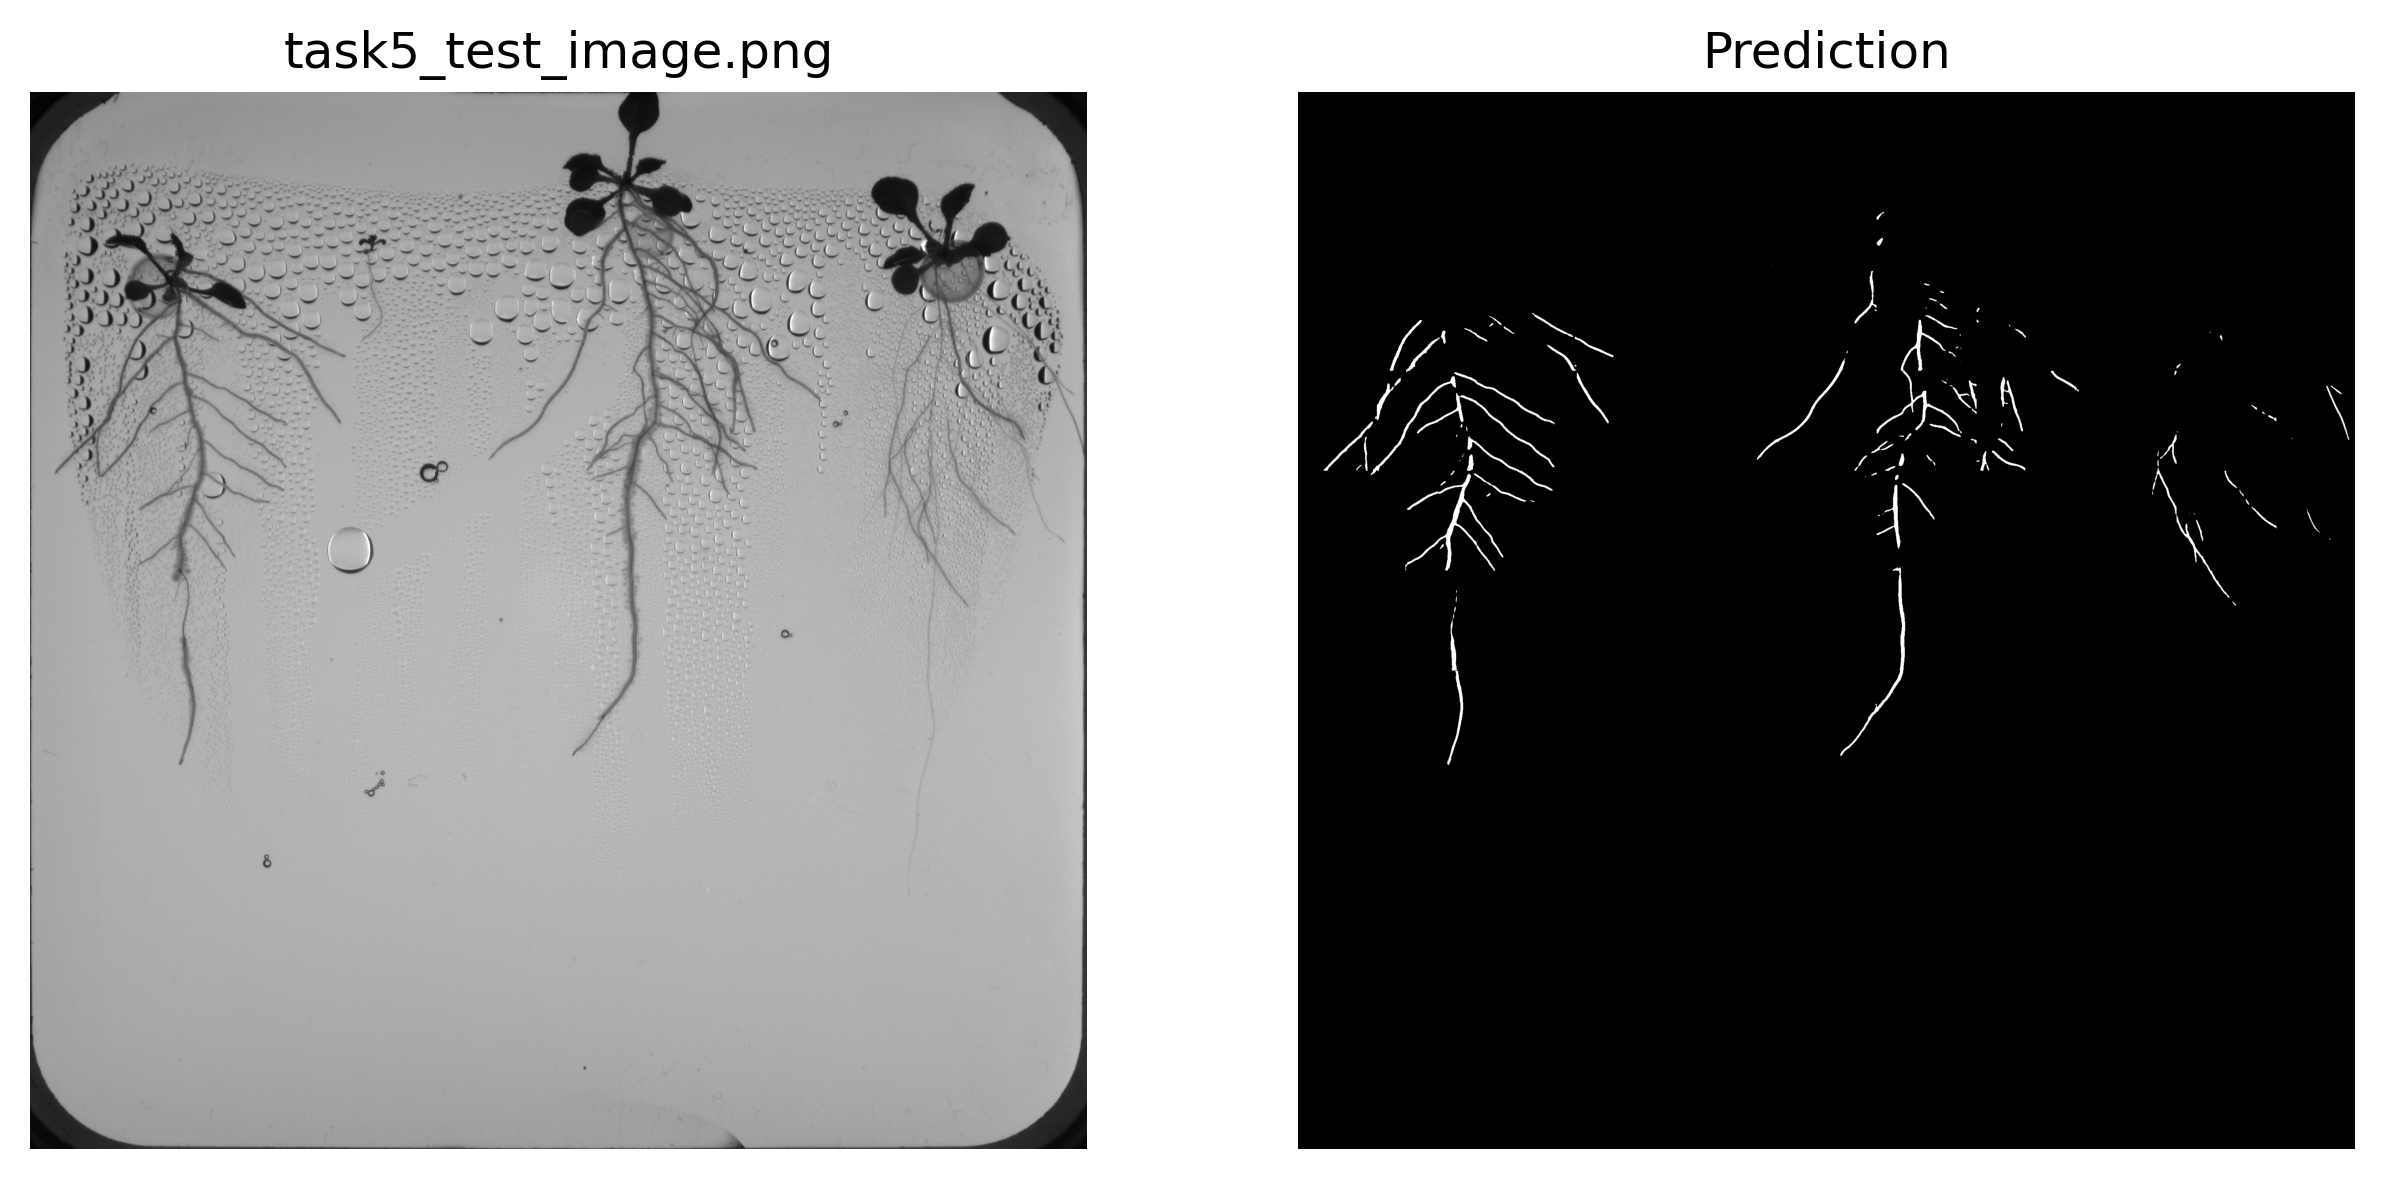

In [42]:
# Pad the petri dish
petri_dish_padded, padding = padder(petri_dish, patch_size)
top_padding, bottom_padding, left_padding, right_padding = padding
print(f"Padding applied: Top={top_padding}, Bottom={bottom_padding}, Left={left_padding}, Right={right_padding}")

# PATCH
test_image_padded = petri_dish_padded

# Convert single-channel grayscale image to 3 channels
test_image_padded_3channel = np.repeat(test_image_padded[..., np.newaxis], 3, axis=-1)

patches = patchify(test_image_padded_3channel, (patch_size, patch_size, 3), step=patch_size)

# Flatten the patches for model prediction
patches_flat = patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize

# PREDICT
predictions = model.predict(patches_flat)
predicted_patches = (predictions > 0.5).astype(np.uint8)

# Reshape predictions back into the patch grid
predicted_patches_reshaped = predicted_patches.reshape(
    patches.shape[0], patches.shape[1], patch_size, patch_size
)

# UNPATCH
predicted_mask = unpatchify(predicted_patches_reshaped, test_image_padded.shape[:2])

# Symmetric cropping to remove padding
predicted_mask_cropped = predicted_mask[
    top_padding:predicted_mask.shape[0] - bottom_padding,
    left_padding:predicted_mask.shape[1] - right_padding
]

# Visualize the results
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask_cropped, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')
plt.show()


In [10]:
predicted_mask.shape, test_image_padded.shape

((2816, 2816), (2816, 2816))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [11]:
# Apply the corrections

## Already done in the previous steps

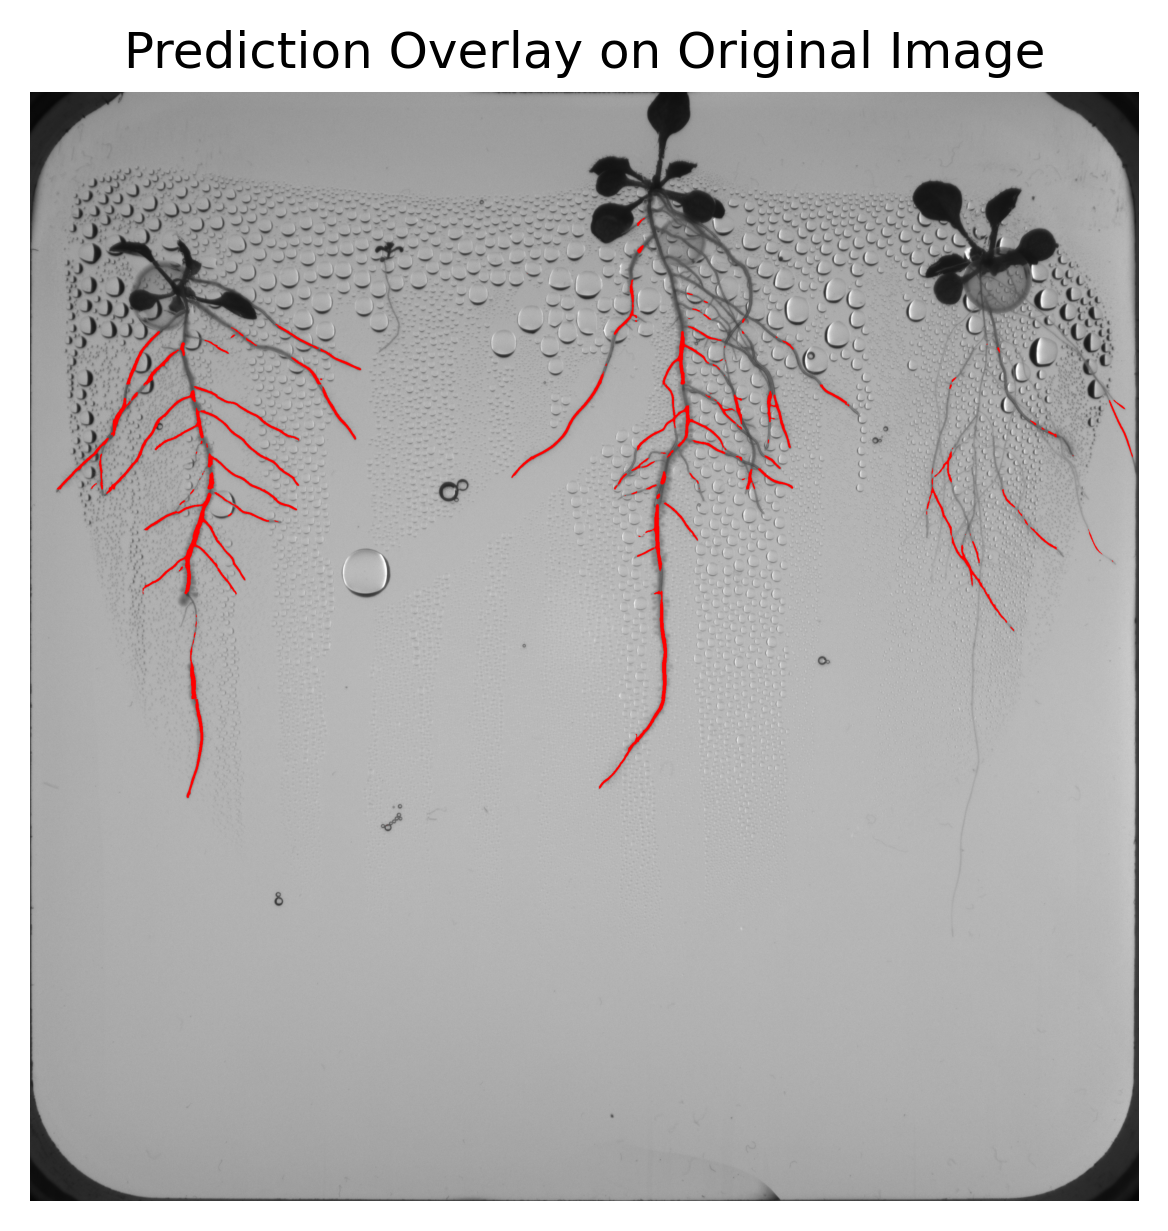

In [43]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.

# Ensure the predicted mask aligns with the original image
assert predicted_mask_cropped.shape == petri_dish.shape, "Shapes of mask and image do not match!"

# Convert the original grayscale image to RGB for overlay
original_image_rgb = cv2.cvtColor(petri_dish, cv2.COLOR_GRAY2RGB)

# Overlay: Highlight the predicted mask on the original image
overlay_image = original_image_rgb.copy()
overlay_image[predicted_mask_cropped > 0] = [255, 0, 0]  # Red overlay for mask

# Plot the overlay
plt.figure(dpi=300)
plt.imshow(overlay_image)
plt.axis('off')
plt.title("Prediction Overlay on Original Image")
plt.show()


In [2]:
import numpy as np
import cv2
import os

def verify_and_save_mask(predicted_mask, original_image, output_dir):
    """
    Verifies requirements and saves the predicted mask.

    Parameters:
        predicted_mask (numpy.ndarray): Predicted mask (binary format).
        original_image (numpy.ndarray): Original input image.
        output_dir (str): Directory to save the predicted mask.

    Requirements:
        - Input/Output size must be the same.
        - Predicted roots must align with the original image.
        - The predicted mask must be binary.
        - Non-root pixels must be 0, root pixels must be 255.
        - Save the mask with the naming convention:
          task5_test_image_prediction_alican_123456.png
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Verify 1: Input/Output size must be the same
    assert predicted_mask.shape == original_image.shape, "Input/Output size mismatch."

    # Verify 2: Predicted mask must be binary
    unique_values = np.unique(predicted_mask)
    assert set(unique_values).issubset({0, 1}), f"Predicted mask is not binary: {unique_values}"

    # Convert binary mask to 0 (non-root) and 255 (root)
    predicted_mask_binary = (predicted_mask * 255).astype(np.uint8)

    # Verify 3: Non-root pixels are 0 and root pixels are 255
    unique_values_after_conversion = np.unique(predicted_mask_binary)
    assert set(unique_values_after_conversion) == {0, 255}, \
        f"Predicted mask contains invalid pixel values: {unique_values_after_conversion}"

    # Verify 4: Alignment with original image
    # This is implicitly ensured if sizes match.

    # Save the predicted mask with the specified naming convention
    filename = "task5_test_image_prediction_michal_232079_v1.png"
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, predicted_mask_binary)
    
    print(f"Predicted mask saved successfully: {save_path}")

# Example usage
predicted_mask_cropped = np.random.randint(0, 2, (256, 256))  # Replace with actual predicted mask
original_image = np.random.randint(0, 256, (256, 256))       # Replace with actual input image
output_dir = "output"

# Run verification and save
verify_and_save_mask(predicted_mask_cropped, original_image, output_dir)


Predicted mask saved successfully: output\task5_test_image_prediction_michal_232079_v1.png
